# Official Neural Network Jupyter Notebook

<div class="alert alert-block alert-info">
<b>Imports:</b> Common imports for NumPy, MatplotLib, Pandas, OS along with Machine Learning imports for keras and tensorflow </div>

In [5]:
# Imports for data generation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
# Imports for Machine Learning
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
from keras.callbacks import History 
history = History()

<div class="alert alert-block alert-warning">
<b>nn_train_test() function:</b> 
    
This function creates the train and test sets a little differently. Instead of using pca to reduce dimensionality, it keeps all the data in anticipation of the Neural Net Framework to deal with filtering through it. The d variable allows you to discretize the grid down further as well.
    
    path --> path to the repository with all your .npy file
    n_future --> number of future days of fire you want to predict (will be 1 for us)
    n_comp --> Doesn't do anything right now
    n_past --> number of past days you want to consider (we can experiment with this)
    d --> The size of the discretized fires you want (i.e. d= 32, returns subset of sequences for 32x32 grids)
    
Outputs:
    
    input_dim is set to a 1-D array of 256 ^ 2 for now! 
    x_train --> x_train in format (batch_size, timesteps, input_dim)
    y_train --> training data in format (batch_size, input_dim)
    pca_array -->  Nothing
    
</div>

In [2]:
def nn_train_test(path, n_past, n_comp, n_future = 1, d = 256):
    x_train_list = []
    y_train_list = []
    count = 0
    for file in os.listdir(r"{path}".format(path = path)):
        if os.path.getsize("{path}\\{file}".format(path = path, file = file)) < 10000000:
            continue
        with open("{path}\\{file}".format(path = path, file = file), 'rb') as f:
            data = pickle.load(f)
        training_fire = data['multiDay']
        if data['Elevation Data'].shape[0] > training_fire.shape[0] and data['Elevation Data'].shape[1] > training_fire.shape[1]:
            elevation_data = data['Elevation Data'][:-1,:-1]
        else:
            elevation_data = data['Elevation Data'][:,:-1]
        
        if data['Topographic Data'].shape[0] > training_fire.shape[0] and data['Topographic Data'].shape[1] > training_fire.shape[1]:
            topographic_data = data['Topographic Data'][:-1,:-1]
        else:
            topographic_data = data['Topographic Data'][:,:-1]
            
        valid_append = []
        for i in range(len(data['Unique Dates']) - n_past):
            if (data['Unique Dates'][i + 3] - data['Unique Dates'][i]).days == 3:
                valid_append.append(i)
        if np.any(data['Elevation Data'] == -9999):
            continue
        if np.any(data['Topographic Data'] == -9999):
            continue
        topographic_data[topographic_data > 13] = 0
        
                
        top_shape = np.array(elevation_data.shape)
        elev_shape = np.array(elevation_data.shape)
        elevation_fire = np.zeros((256, 256))
        fuel_moisture_fire = np.zeros((256,256))
        shape = np.array(training_fire.shape) 
        fire = np.where(training_fire[1] == 1)
        x_center, y_center = int(np.median(fire[0])), int(np.median(fire[1]))
        if shape[0] < n_past + n_future:
            continue
        standard_fire = np.zeros((len(training_fire), 256, 256))    
        if shape[1] > 255 or shape[2] > 255:
            # could not broadcast input array from shape (39,350,325) into shape (39,512,416)
            xLow = x_center - 128 
            xHi = shape[1] - x_center
            yLow = y_center - 128
            yHi = shape[2] - y_center 
            if shape[1] > 255:  
                if xLow < 0:
                    xHi = x_center + 128 - xLow
                    xLow = 0
                elif xHi < 128:       
                    xLow = x_center - 256 + xHi
                    xHi = shape[1]                   
                else:
                    xLow = x_center - 128
                    xHi = x_center + 128
            else:            
                xLow = 0
                xHi = shape[1]
            if shape[2] > 255:
                if yLow < 0:
                    yHi = y_center + 128 - yLow
                    yLow = 0
                elif yHi < 128:
                    yLow = y_center - 256 + yHi
                    yHi = shape[2]
                else:
                    yLow = y_center - 128
                    yHi = y_center + 128
            else:
                yLow = 0
                yHi = shape[2]
            standard_fire[:shape[0], :min(256, shape[1]), :min(256, shape[2])] = training_fire[:, xLow: xHi, yLow: yHi]  
            elevation_fire[:min(256, elev_shape[0]), :min(256, elev_shape[1])] = elevation_data[xLow: xHi, yLow: yHi]
            fuel_moisture_fire[:min(256, top_shape[0]), :min(256, top_shape[1])] = topographic_data[xLow: xHi, yLow: yHi]
        else: 
            standard_fire[:shape[0], :shape[1], :shape[2]] = training_fire
            elevation_fire[:min(256, elev_shape[0]), :min(256, elev_shape[1])] = elevation_data
            fuel_moisture_fire[:min(256, top_shape[0]), :min(256, top_shape[1])] = topographic_data
        
        pca_fire = standard_fire
        pca_elev = elevation_fire.reshape((1, 256, 256))
        pca_fuel = fuel_moisture_fire.reshape((1, 256, 256))
        
        for i in range(0 , len(training_fire) - n_future - n_past + 1):
            if i not in valid_append:
                continue
            shape = pca_fire[i : i + n_past].shape
            a = np.zeros((shape[0] + 2, shape[1], shape[2]))
            a[:3] = pca_fire[i : i + n_past]
            a[3:4] = pca_elev 
            a[4:5] = pca_fuel
            for j in np.arange(0, 255, d):
                for k in np.arange(0, 255, d):
                    x_train_list.append(a[:, j:j+d, k:k+d])
                    y_train_list.append(pca_fire[i + n_past: i + n_past + n_future, j:j+d, k:k+d])   
    x_train = np.array(x_train_list)
    y_train = np.array(y_train_list)  
    print(x_train.shape, y_train.shape)
    return x_train, y_train

<div class="alert alert-block alert-warning">
<b>RNN Inputs:</b> 
We are declaring below that the number of future days we want to predict is 1, and we can vary the number of past days
    we want to predict (I have the default as 3 for now)

</div>

In [3]:
n_future = 1
n_comp = 10
n_past = 3
discretization_amount = d = 64 # 256 means we keep the whole fire grid

<div class="alert alert-block alert-warning">
<b>Input Data for Training:</b> 
    Below, we get the input data from December 2018! 
</div>

In [4]:
%%capture 
# We are suppressing print statements and warning messages w/ above line
path = "C:\\Users\\nico\\Desktop\\Stanford\\OneDrive - Stanford\\Courses\\CS229\\finalproject\\data\\United_States_Fires\\United_States_2018_Fires\\jan\\storage"
months = ['feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug' ,'sep', 'oct', 'nov', 'dec']
x_train, y_train = nn_train_test(path, n_past = n_past, n_comp = n_comp, n_future = n_future, d = d)
for month in months:
    path = "C:\\Users\\nico\\Desktop\\Stanford\\OneDrive - Stanford\\Courses\\CS229\\finalproject\\data\\United_States_Fires\\United_States_2018_Fires\\{mon}\\storage".format(mon = month)
    x, y  = nn_train_test(path, n_past = n_past, n_comp = n_comp, n_future = n_future, d = d)
    if len(x) == 0:
        continue
    x_train = np.vstack((x_train, x))
    y_train = np.vstack((y_train, y))
    

In [141]:
x_train, y_train = x_train.reshape((int(x_train.shape[0]), 1, d, d, 5)), y_train.reshape((int(y_train.shape[0]), d*d))
x_train.shape, y_train.shape

((8560, 1, 64, 64, 5), (8560, 4096))

In [7]:
shuffler = np.random.permutation(len(x_train))
x_train = x_train[shuffler]
y_train = y_train[shuffler]

In [ ]:
regressor = Sequential()
# d = 64
act = "sigmoid"
batch_normalization = False
pad = "valid"
layersd = 1 #1
layers2d = 0 #0
pooling2d = 0
layers4d = 0 #0
pooling4d = 0
pooling = True ## DO NOT CHANGE
dropout = 0.1
learning_rate = .01
epochs = 200
densed = 0 # 0
dense = 1
train_range = range(0, len(x_train)) #range(0,50)#
t = len(train_range)



if layersd: 
    regressor.add(tf.keras.layers.Conv3D(filters = 32, kernel_size = (1,5,5), padding = pad, activation = act, input_shape = x_train[0].shape))
    if pooling and layersd:
        regressor.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding="valid"))
        
    if batch_normalization and layersd:
        regressor.add(tf.keras.layers.BatchNormalization(center=True, scale=True))

for i in range(layersd - 1):# CHANGE TO SIGMOID
    regressor.add(tf.keras.layers.Conv3D(filters = 32, kernel_size = (1,3,3), padding = pad, activation = "sigmoid"))
    
    if pooling and layersd:
        regressor.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding="valid")) # CHANGE TO RELU
        
    if batch_normalization and layersd:
        regressor.add(tf.keras.layers.BatchNormalization(center=True, scale=True))
        

        
if layersd:
    regressor.add(Dropout(dropout))

for i in range(layers2d):
    regressor.add(tf.keras.layers.Conv3D(filters = 64, kernel_size = (1,3,3), padding = pad, activation = "relu"))# CHANGE TO RELU

if (pooling and layers2d) or pooling2d:
    regressor.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding="valid"))
    
if batch_normalization and layers2d:
    regressor.add(tf.keras.layers.BatchNormalization(center=True, scale=True))


for i in range(layers4d):# CHANGE TO RELU
    regressor.add(tf.keras.layers.Conv3D(filters = 16, kernel_size = (1,3,3), padding = pad, activation = "relu"))

if (pooling and layers4d) or pooling4d:
    regressor.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding="valid"))

if batch_normalization and layers4d:
    regressor.add(tf.keras.layers.BatchNormalization(center=True, scale=True))

regressor.add(tf.keras.layers.Flatten())

for i in range(densed):
    regressor.add(tf.keras.layers.Dense(units = d, activation = 'relu'))
    
for i in range(dense):
    regressor.add(tf.keras.layers.Dense(units = d*d, activation = 'sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience = 2),
    tf.keras.callbacks.ModelCheckpoint(filepath='3D-Conv-Model-History-3.h5'),   
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    history
]

regressor.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['acc'])

history = regressor.fit(x_train[train_range].reshape(t, 1, d, d, 5), y_train[train_range].reshape((t, d*d)), epochs = epochs, validation_split = 0.2, batch_size = 1, callbacks = my_callbacks)
regressor.summary()

import pickle
with open("C:\\Users\\nico\\Desktop\\Stanford\\OneDrive - Stanford\\Courses\\CS229\\finalproject\\scripts\\history-4096.pkl","w") as f:
    f.write(str(history.history))


Epoch 1/200
6848/6848 [==============================] - 2905s 424ms/step - loss: 0.4450 - acc: 0.0018 - val_loss: 0.1459 - val_acc: 0.0000e+00
Epoch 2/200
6848/6848 [==============================] - 2843s 415ms/step - loss: 0.1372 - acc: 0.0023 - val_loss: 0.1470 - val_acc: 0.0000e+00
Epoch 3/200
6848/6848 [==============================] - 2937s 429ms/step - loss: 0.1343 - acc: 0.0010 - val_loss: 0.1397 - val_acc: 0.0000e+00
Epoch 4/200
6848/6848 [==============================] - 2903s 424ms/step - loss: 0.1327 - acc: 0.0010 - val_loss: 0.1387 - val_acc: 5.8411e-04
Epoch 5/200
6848/6848 [==============================] - 2913s 425ms/step - loss: 0.1320 - acc: 7.3014e-04 - val_loss: 0.1395 - val_acc: 5.8411e-04
Epoch 6/200
1011/6848 [===>..........................] - ETA: 40:21 - loss: 0.1510 - acc: 0.0000e+00

In [22]:
from keras.models import load_model
regressor = load_model('3D-Conv-200-example-overfitting-2.h5')

OSError: SavedModel file does not exist at: 3D-Conv-200-example-overfitting-2.h5\{saved_model.pbtxt|saved_model.pb}

In [19]:
regressor.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_31 (Conv3D)           (None, 1, 62, 62, 64)     2944      
_________________________________________________________________
max_pooling3d_50 (MaxPooling (None, 1, 31, 31, 64)     0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 1, 31, 31, 64)     256       
_________________________________________________________________
dropout_28 (Dropout)         (None, 1, 31, 31, 64)     0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 61504)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 4096)              251924480 
Total params: 251,927,680
Trainable params: 251,927,552
Non-trainable params: 128
_____________________________________

In [20]:
np.unique(np.where(y_train[0:200] > 0)[0])

array([  2,   7,   8,  11,  15,  17,  19,  21,  23,  30,  36,  37,  41,
        45,  48,  59,  66,  67,  74,  78,  79,  80,  84,  85,  87,  89,
        93,  97, 105, 107, 110, 117, 119, 121, 122, 123, 127, 128, 130,
       133, 135, 140, 143, 144, 145, 148, 149, 150, 152, 156, 162, 166,
       168, 171, 179, 184, 195, 196], dtype=int64)

In [31]:
print(history.history)

{}


In [28]:
history = regressor.history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

KeyError: 'loss'

In [48]:
np.unique(np.where(y_train[0:250] > 0)[0])

array([  2,   7,   8,  11,  15,  17,  19,  21,  23,  30,  36,  37,  41,
        45,  48,  59,  66,  67,  74,  78,  79,  80,  84,  85,  87,  89,
        93,  97, 105, 107, 110, 117, 119, 121, 122, 123, 127, 128, 130,
       133, 135, 140, 143, 144, 145, 148, 149, 150, 152, 156, 162, 166,
       168, 171, 179, 184, 195, 196, 202, 205, 206, 207, 211, 214, 218,
       224, 229, 232, 245, 246, 248, 249], dtype=int64)

C:\Users\nico\AppData\Local\Temp/ipykernel_10364/174710280.py:9: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(img,cmap=cmap, norm=norm,boundaries=bounds,ticks=[0,1])
C:\Users\nico\AppData\Local\Temp/ipykernel_10364/174710280.py:9: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(img,cmap=cmap, norm=norm,boundaries=bounds,ticks=[0,1])


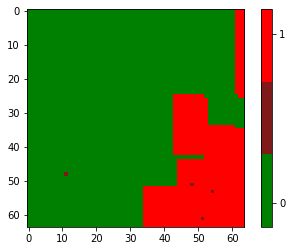

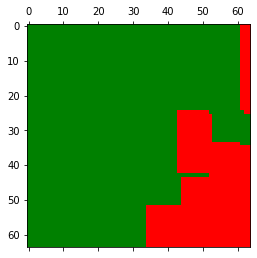

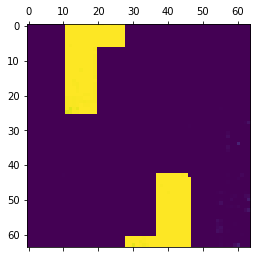

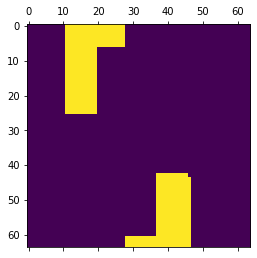

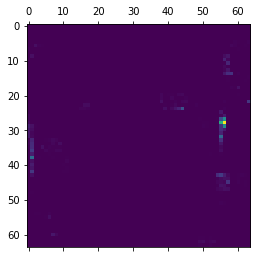

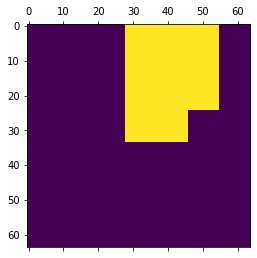

In [60]:
import matplotlib as mpl
x = x_train.reshape((x_train.shape[0], 5, d, d))
cmap = mpl.colors.ListedColormap(['green', [.5, .1, .1], 'red'])
bounds=[-.1, 0.2, .8, 1.1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
predict_test = regressor.predict(x_train[19].reshape((1, 1, d, d, 5)))
b = predict_test
img = plt.imshow(b.reshape((d, d)), cmap = cmap)
plt.colorbar(img,cmap=cmap, norm=norm,boundaries=bounds,ticks=[0,1])
plt.show()
plt.matshow(y_train[19].reshape((d, d)), cmap = cmap)
plt.show()
predict_test = regressor.predict(x_train[2].reshape((1, 1, d, d, 5)))
p = predict_test
plt.matshow(p.reshape((d, d)))
plt.show()
plt.matshow(y_train[2].reshape((d, d)))
predict_test = regressor.predict(x_train[206].reshape((1, 1, d, d, 5)))
p = predict_test
plt.matshow(p.reshape((d, d)))
plt.show()
plt.matshow(y_train[206].reshape((d, d)))
plt.show()

In [147]:
from keras.models import load_model
regressor = load_model('3D-Conv-Model-History-2.h5')

C:\Users\nico\AppData\Local\Temp/ipykernel_10364/579477427.py:22: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(img0,cmap=cmap,boundaries=bounds,ticks=[0,1], ax = axs[0], fraction=0.046, pad=0.04)
C:\Users\nico\AppData\Local\Temp/ipykernel_10364/579477427.py:25: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(img1,cmap=cmap,boundaries=bounds,ticks=[0,1], ax = axs[1], fraction=0.046, pad=0.04)


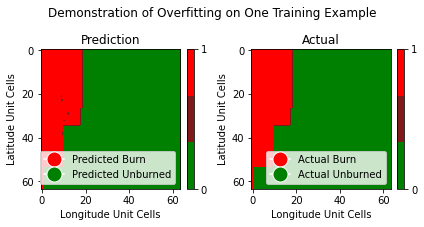

In [148]:
import matplotlib as mpl
from matplotlib.lines import Line2D

i = 162
x = x_train.reshape((x_train.shape[0], 5, d, d))
cmap = mpl.colors.ListedColormap(['green', [.5, .1, .1], 'red'])
bounds=[0, 0.2, .8, 1]
predict_test = regressor.predict(x_train[i].reshape((1, 1, d, d, 5)))
b = predict_test

fig, axs = plt.subplots(1, 2)
img0 = axs[0].imshow(b.reshape((d, d)), cmap = cmap)

axs[0].set_xlabel('Longitude Unit Cells')
axs[0].set_ylabel('Latitude Unit Cells')
axs[1].set_xlabel('Longitude Unit Cells')
axs[1].set_ylabel('Latitude Unit Cells')

axs[0].set_title('Prediction')
axs[1].set_title('Actual')
plt.suptitle('Demonstration of Overfitting on One Training Example')
plt.colorbar(img0,cmap=cmap,boundaries=bounds,ticks=[0,1], ax = axs[0], fraction=0.046, pad=0.04)

img1 = axs[1].imshow(y_train[i].reshape((d, d)), cmap = cmap)
plt.colorbar(img1,cmap=cmap,boundaries=bounds,ticks=[0,1], ax = axs[1], fraction=0.046, pad=0.04)
fig.tight_layout()
fig.subplots_adjust(bottom=0.3)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Predicted Burn',
                          markerfacecolor='r', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Predicted Unburned',
                          markerfacecolor='g', markersize=15)]
        
axs[0].legend(handles=legend_elements, loc='lower right')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Actual Burn',
                          markerfacecolor='r', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Actual Unburned',
                          markerfacecolor='g', markersize=15)]
axs[1].legend(handles=legend_elements, loc='lower right')
plt.savefig("./../images/overfitting-cnn.png")
plt.show()


In [10]:
regressor.history.history

{}

In [65]:
path = "C:\\Users\\nico\\Desktop\\Stanford\\OneDrive - Stanford\\Courses\\CS229\\finalproject\\data\\United_States_Fires\\United_States_2017_Fires\\nov\\storage".format(mon = month)
x, y  = nn_train_test(path, n_past = n_past, n_comp = n_comp, n_future = n_future, d = d)

(1232, 5, 64, 64) (1232, 1, 64, 64)


In [71]:
x_test, y_test = x.reshape((int(x.shape[0]), 1, d, d, 5)), y.reshape((int(y.shape[0]), d*d))
predict_test = regressor.predict(x_test)
p = predict_test

X


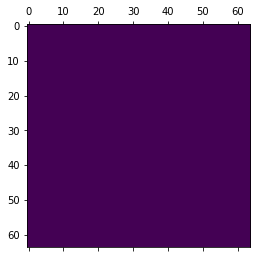

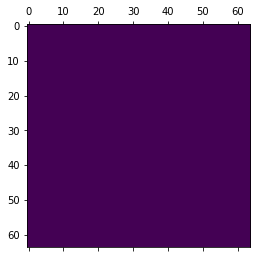

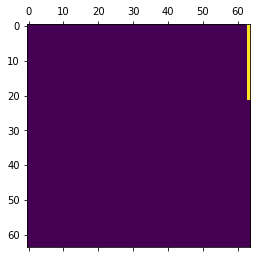

Prediction


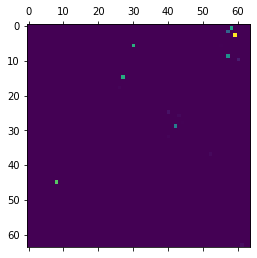

Actual


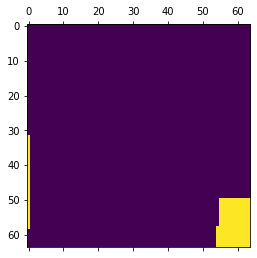

In [84]:
x_test = x_test.reshape((int(x.shape[0]), 5, d, d))
i = 28
print("X")
plt.matshow(x_test[i][0])
plt.matshow(x_test[i][1])
plt.matshow(x_test[i][2])
plt.show()
print("Prediction")
prediction = p[i].reshape((64,64))
plt.matshow(prediction)
plt.show()

plt.show()
print("Actual")

plt.matshow(y_test[i].reshape((64,64)))